# Visualizing features with captum.optim

This notebook demonstrates the use of the `captum.optim` submodule for visualizing features for a InceptionV1 model imported from Caffe. The `optim` submodule shows the increasing complexity of the features learned as we go deeper into the model. We also briefly touch on the `ImageTensor` class for easily loading and visualizing tensors that are also images.

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision
from captum.optim._models.inception_v1 import googlenet

import captum.optim as opt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## ImageTensor

The `ImageTensor` class is a wrapper around `torch.Tensor` that allows for easy loading and viewing of images.

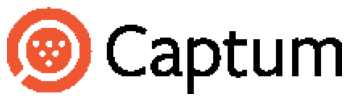

In [2]:
# Use ImageTensor.open() with a URL or filepath to load an image
t = opt.ImageTensor.open(
    "https://raw.githubusercontent.com/pytorch/captum/master/website/static/img/captum_logo.png"
)
# Use show() to quickly view the image.
t.show()

## InputOptimization

`InputOptimization` is the core function for visualizing features with `captum.optim`.

It takes five arguments:
- The model whose feature(s) we are visualizing
- A torch.nn.Module object that generates inputs to the model (e.g. NaturalImage)
- A transformation or series of transformations preprocessing the input before passing to the model
- A list of target layers from the model
- A loss function based on the target layers

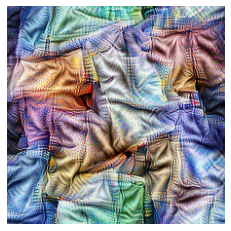

In [3]:
# Load the model
model = googlenet(pretrained=True).to(device)

# Initialize an input - NaturalImage uses FFT parameterization and color decorrelation
image = opt.images.NaturalImage((224, 224)).to(device) # This creates a Module that returns an ImageTensor

# Initialize a series of transformations
transforms = torch.nn.Sequential(
    # Random translation, scaling, and rotation to help with visualization quality.
    # Padding is used to avoid transform artifacts and then it's cropped away.
    torch.nn.ReflectionPad2d(16),
    opt.transform.RandomSpatialJitter(16),
    opt.transform.RandomScale(scale=(1, 0.975, 1.025, 0.95, 1.05)),
    torchvision.transforms.RandomRotation(degrees=(-5,5)),
    opt.transform.RandomSpatialJitter(8),
    opt.transform.CenterCrop((224,224)),
)
# Choose a target layer to optimize
target = model.mixed4c

# Create a loss function based on the target layer
loss_fn = opt.loss.ChannelActivation(target, 368)

# Initialize InputOptimization and run optimize
obj = opt.InputOptimization(model, loss_fn, image, transforms)
history = obj.optimize(opt.optimization.n_steps(128))

image().show()

For convenience, we can create a helper function for visualizing different layers in our model.

In [4]:
def visualize(model, target, channel):
    image = opt.images.NaturalImage((224, 224)).to(device)
    transforms = torch.nn.Sequential(
        torch.nn.ReflectionPad2d(16),
        opt.transform.RandomSpatialJitter(16),
        opt.transform.RandomScale(scale=(1, 0.975, 1.025, 0.95, 1.05)),
        torchvision.transforms.RandomRotation(degrees=(-5,5)),
        opt.transform.RandomSpatialJitter(8),
        opt.transform.CenterCrop((224,224)),
    )
    loss_fn = opt.loss.ChannelActivation(target, channel)
    obj = opt.InputOptimization(model, loss_fn, image, transforms)
    history = obj.optimize(opt.optimization.n_steps(128))
    image().show()

With visualization, we can see that deeper features detect for increasingly complex elements.

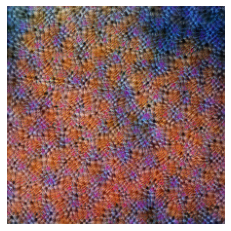

In [5]:
visualize(model, model.mixed3a.conv_5x5_relu, 15)

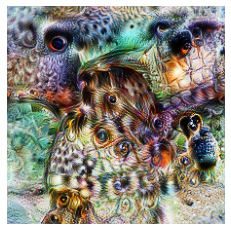

In [6]:
visualize(model, model.mixed5b.conv_5x5, 19)

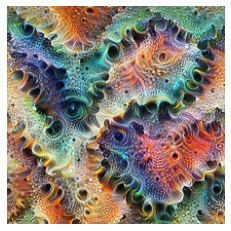

In [7]:
visualize(model, model.mixed4d.conv_1x1, 21)

We can also visualize different classes in the final layer and see how they are similar to their corresponding ImageNet labels.

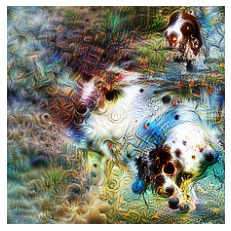

In [8]:
visualize(model, model.fc, 5) # No idea what this class is

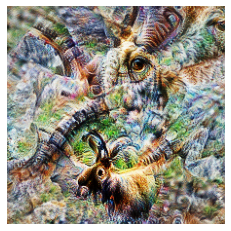

In [9]:
visualize(model, model.fc, 9) # Some sort of animal?

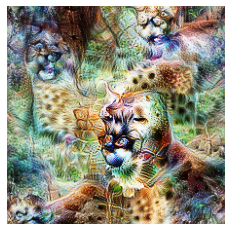

In [10]:
visualize(model, model.fc, 11)